In [ ]:
from textblob import TextBlob



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 626.3/626.3 kB 3.6 MB/s eta 0:00:00


# **Problem Statement**

For a financial company, customer complaints carry a lot of importance, as they are often an indicator of the shortcomings in their products and services. If these complaints are resolved efficiently in time, they can bring down customer dissatisfaction to a minimum and retain them with stronger loyalty. This also gives them an idea of how to continuously improve their services to attract more customers.


These customer complaints are unstructured text data. So, traditionally, companies need to allocate the task of evaluating and assigning each ticket to the relevant department, which then further gets assigned to a particular support employee. This becomes tedious as the company grows and has a large customer base.


***In this case study, I will be working as an NLP engineer for a financial company that wants to automate its customer support ticket system. As a financial company, the firm has many products and services, such as credit cards, banking and mortgages/loans. So, need to build a model that is able to classify customer complaints based on the products/services. By doing so, company can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.***

## 1. Importing the necessary libraries

In [2]:
import json
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
from textblob import TextBlob

#Importing libraries required for the case study and to plot charts
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px
%matplotlib inline

#Importing Regular Expressions for String manipulation
import re

# hide warnings
import warnings
warnings.filterwarnings('ignore')

## 2. Loading the data

In [3]:
# Opening JSON file
j = open('/content/drive/MyDrive/Case Study NLP - Automatic Ticket Classification/complaints-2021-05-14_08_16.json',)

# Returns JSON object as a dictionary
data = json.load(j)

# Create a dataframe out of dictionary
df = pd.json_normalize(data)

In [4]:
# Inspect the dataframe to understand the given data.
df.head()

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [5]:
#shape of dataframe
df.shape

(78313, 22)

In [6]:
#print the column names
df.columns

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')

## 3. Data Preparation

In [7]:
#Assign new column names
df = df[['_source.complaint_what_happened','_source.product','_source.sub_product',]]
df.head()

,_source.complaint_what_happened,_source.product,_source.sub_product
0,,Debt collection,Credit card debt
1,Good morning my name is XXXX XXXX and I apprec...,Debt collection,Credit card debt
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Credit card or prepaid card,General-purpose credit card or charge card
3,,Mortgage,Conventional home mortgage
4,,Credit card or prepaid card,General-purpose credit card or charge card


In [8]:
# lets rename the column names to be more read friendly

df = df.rename(columns={'_source.complaint_what_happened': 'complaint_text', '_source.product': 'category','_source.sub_product': 'sub_category'})
df.head()

,complaint_text,category,sub_category
0,,Debt collection,Credit card debt
1,Good morning my name is XXXX XXXX and I apprec...,Debt collection,Credit card debt
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Credit card or prepaid card,General-purpose credit card or charge card
3,,Mortgage,Conventional home mortgage
4,,Credit card or prepaid card,General-purpose credit card or charge card


In [9]:
# lets merge the category and sub-category this will help us in deciding the topics after NMF modelling
df['category'] = df['category'] + '+' + df['sub_category']
df = df.drop(['sub_category'],axis= 1)
df.head()

,complaint_text,category
0,,Debt collection+Credit card debt
1,Good morning my name is XXXX XXXX and I apprec...,Debt collection+Credit card debt
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Credit card or prepaid card+General-purpose cr...
3,,Mortgage+Conventional home mortgage
4,,Credit card or prepaid card+General-purpose cr...


In [10]:
# lets check the nan complaints
df.complaint_text.isnull().sum()

0

In [11]:
# lets check the empty string complaints
len(df[df['complaint_text']==''])

57241

In [12]:
#Assign nan in place of blanks in the complaints column
# lets replace empty complain with nan value
df[df['complaint_text']==''] = np.nan
df.complaint_text.isnull().sum()

57241

In [13]:
#Remove all rows where complaints column is nan
# Lets drop all the rows where complaint_text is null
df = df[~df['complaint_text'].isnull()]
df.complaint_text.isnull().sum()

0

In [14]:
df.head()

,complaint_text,category
1,Good morning my name is XXXX XXXX and I apprec...,Debt collection+Credit card debt
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Credit card or prepaid card+General-purpose cr...
10,Chase Card was reported on XX/XX/2019. However...,"Credit reporting, credit repair services, or o..."
11,"On XX/XX/2018, while trying to book a XXXX XX...","Credit reporting, credit repair services, or o..."
14,my grand son give me check for {$1600.00} i de...,Checking or savings account+Checking account


In [15]:
df.shape

(21072, 2)

## 4. Text Preprocessing

In [16]:
# Write your function here to clean the text and remove all the unnecessary elements.
def clean_texts(text):
    #Make the text lowercase
    text=text.lower()

    #Remove text in square brackets
    text=re.sub(r'\[.*?\]','',text)

    #Remove punctuation
    text=re.sub(r'[%s]%re.escape(string.punctuation)','',text)

    #Remove words containing numbers
    text = re.sub(r'\w*\d\w*', '', text)

    return text

In [17]:
#Cleaning df['complaint_what_happened']
df['complaint_text']= df['complaint_text'].apply(lambda x: clean_texts(x))

In [18]:
df.head()

,complaint_text,category
1,good morning my name is xxxx xxxx and i apprec...,Debt collection+Credit card debt
2,i upgraded my xxxx xxxx card in xx/xx/ and was...,Credit card or prepaid card+General-purpose cr...
10,"chase card was reported on xx/xx/. however, fr...","Credit reporting, credit repair services, or o..."
11,"on xx/xx/, while trying to book a xxxx xxxx ...","Credit reporting, credit repair services, or o..."
14,my grand son give me check for {$.} i deposit ...,Checking or savings account+Checking account


In [19]:
#Write your function to Lemmatize the texts
def lemma_texts(text):

    # Initialize empty list to store lemmas
    lemma_list = []

    # Extract lemmas of given text and add to the list 'sent'
    document = nlp(text)
    for word in document:
        lemma_list.append(word.lemma_)

    # return string converted form of the list of lemmas
    return " ".join(lemma_list)

In [20]:
# Add a column for lemmatized complaints to the dataframe
df["lemmatized_complaint"] =  df.apply(lambda x: lemma_texts(x['complaint_text']), axis=1)

# View the dataframe
df.head()

,complaint_text,category,lemmatized_complaint
1,good morning my name is xxxx xxxx and i apprec...,Debt collection+Credit card debt,good morning my name be xxxx xxxx and I apprec...
2,i upgraded my xxxx xxxx card in xx/xx/ and was...,Credit card or prepaid card+General-purpose cr...,I upgrade my xxxx xxxx card in xx / xx/ and be...
10,"chase card was reported on xx/xx/. however, fr...","Credit reporting, credit repair services, or o...","chase card be report on xx / xx/. however , fr..."
11,"on xx/xx/, while trying to book a xxxx xxxx ...","Credit reporting, credit repair services, or o...","on xx / xx/ , while try to book a xxxx xxxx ..."
14,my grand son give me check for {$.} i deposit ...,Checking or savings account+Checking account,my grand son give I check for { $ . } I deposi...


In [21]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints
df_clean=df[['complaint_text','lemmatized_complaint']]

In [22]:
df_clean.head()

,complaint_text,lemmatized_complaint
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...
2,i upgraded my xxxx xxxx card in xx/xx/ and was...,I upgrade my xxxx xxxx card in xx / xx/ and be...
10,"chase card was reported on xx/xx/. however, fr...","chase card be report on xx / xx/. however , fr..."
11,"on xx/xx/, while trying to book a xxxx xxxx ...","on xx / xx/ , while try to book a xxxx xxxx ..."
14,my grand son give me check for {$.} i deposit ...,my grand son give I check for { $ . } I deposi...


In [23]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [24]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [25]:
#Write your function to extract the POS tags

# Extracting singular nouns
def singular_nouns(text):


    # Creating a textblob object
    text_blob = TextBlob(text)

    # extracting words with tags 'NN', joining them and return
    return ' '.join([ word for (word,tag) in text_blob.tags if tag == "NN"])


In [26]:
# Applying the function to create a new column containing only singular nouns
df_clean["complaint_POS_removed"] =  df_clean.apply(lambda x: singular_nouns(x['lemmatized_complaint']), axis=1)

# View the dataframe
df_clean.head()

,complaint_text,lemmatized_complaint,complaint_POS_removed
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember service ask ...
2,i upgraded my xxxx xxxx card in xx/xx/ and was...,I upgrade my xxxx xxxx card in xx / xx/ and be...,card agent upgrade date agent information orde...
10,"chase card was reported on xx/xx/. however, fr...","chase card be report on xx / xx/. however , fr...",card application identity consent service cred...
11,"on xx/xx/, while trying to book a xxxx xxxx ...","on xx / xx/ , while try to book a xxxx xxxx ...",try book xxxx ticket offer ticket card informa...
14,my grand son give me check for {$.} i deposit ...,my grand son give I check for { $ . } I deposi...,son chase account fund bank account pay money ...


## 5. Exploratory Data Analysis

In [27]:
#lenght of character in 'complaint_POS_removed'
char_len=[len(x) for x in df_clean['complaint_POS_removed']]
char_len[:15]

[159, 101, 67, 414, 155, 7, 650, 582, 1172, 51, 27, 206, 126, 138, 620]

Text(0, 0.5, 'No. of Complaints')

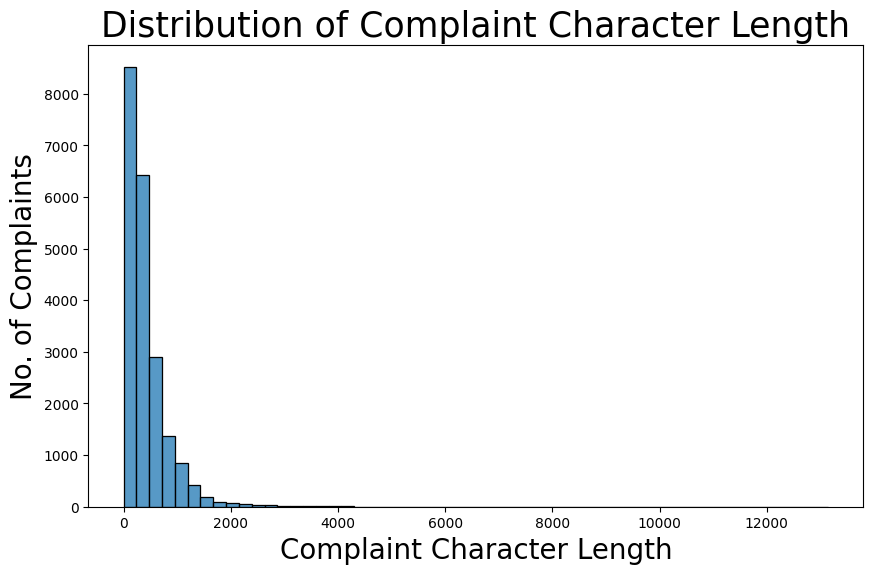

In [28]:
## Write your code here to visualise the data according to the 'Complaint' character length
plt.figure(figsize=[10,6])
sns.histplot(data = char_len,bins=55)
plt.title('Distribution of Complaint Character Length', fontsize=25)
plt.xlabel('Complaint Character Length',size=20)
plt.ylabel('No. of Complaints',size=20)

In [29]:
!pip install wordcloud

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.1/511.1 kB 7.0 MB/s eta 0:00:00


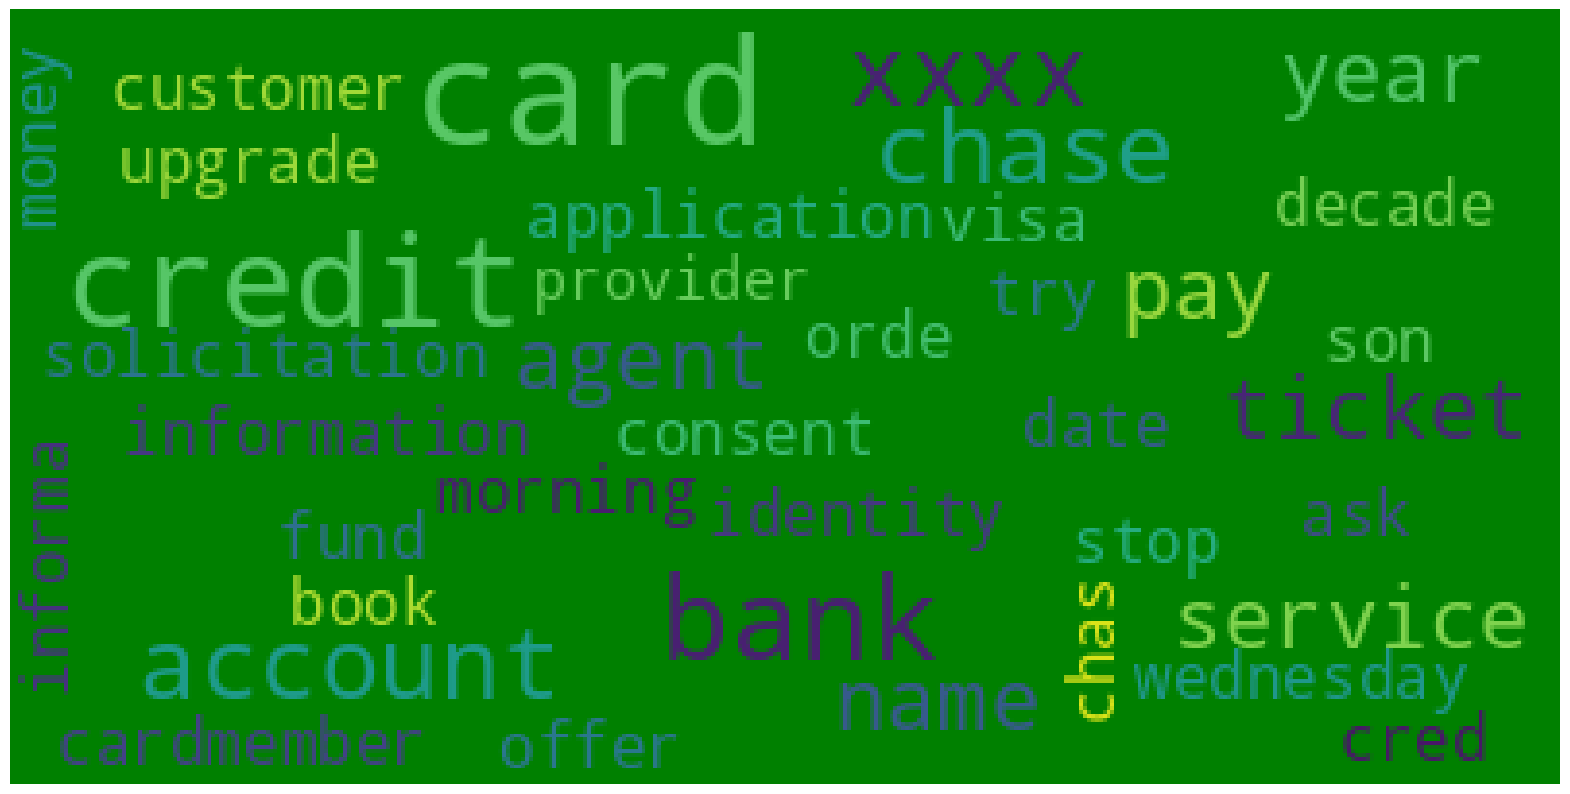

In [30]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text
from wordcloud import WordCloud, STOPWORDS

stop_words = set(STOPWORDS)
word_cloud = WordCloud(
                          background_color='green',
                          stopwords=stop_words,
                          max_font_size=38,
                          max_words=38,
                          random_state=42
                         ).generate(str(df_clean['complaint_POS_removed']))

fig = plt.figure(figsize=(20,16))
plt.imshow(word_cloud)
plt.axis('off')
plt.show()


In [9]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer

In [32]:
def get_top_n_bigram(text, ngram=1, top=None):
    vec = CountVectorizer(ngram_range=(ngram, ngram), stop_words='english').fit(text)
    bag_of_words = vec.transform(text)

    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]

    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:top]

In [33]:
top_30_unigrams = get_top_n_bigram(df_clean.complaint_POS_removed, ngram=1, top=30)
top_30_bigrams = get_top_n_bigram(df_clean.complaint_POS_removed, ngram=2, top=30)
top_30_trigrams = get_top_n_bigram(df_clean.complaint_POS_removed, ngram=3, top=30)

In [34]:
#Print the top 10 words in the unigram frequency
print('Top 10 unigrams:\n')

df_unigram = pd.DataFrame(top_30_unigrams, columns = ['unigram' , 'count'])
df_unigram.head(10)

Top 10 unigrams:



,unigram,count
0,chase,49212
1,account,47913
2,xxxx,43304
3,credit,34300
4,card,29633
5,bank,28503
6,payment,21338
7,time,16281
8,charge,15153
9,day,13073


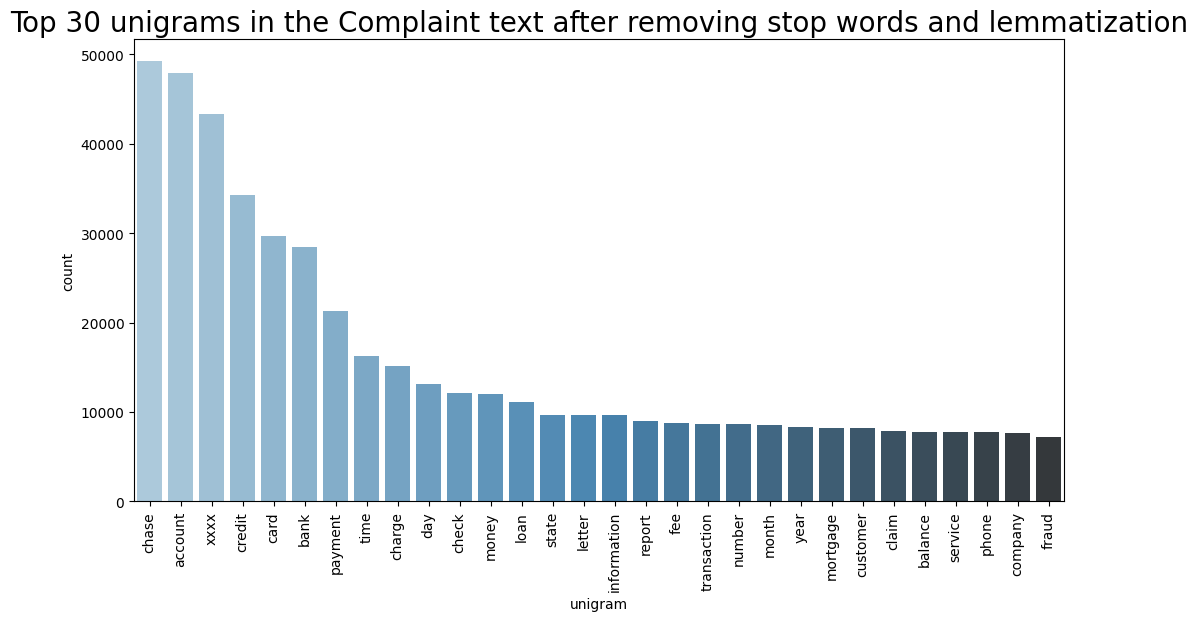

In [35]:
# Plot the top 30 unigrams
plt.figure(figsize=(12,6))
sns.barplot(x='unigram', y='count', data=df_unigram, palette="Blues_d")
plt.xticks(rotation=90)
plt.title("Top 30 unigrams in the Complaint text after removing stop words and lemmatization", fontsize=20)
plt.show()

In [36]:
#Print the top 10 words in the bigram frequency
print('Top 10 bigrams:\n')

df_bigram = pd.DataFrame(top_30_bigrams, columns = ['bigram' , 'count'])
df_bigram.head(10)

Top 10 bigrams:



,bigram,count
0,credit card,12878
1,xxxx xxxx,6249
2,credit report,3964
3,customer service,3082
4,chase credit,3064
5,chase bank,2935
6,account chase,2761
7,bank account,2751
8,chase account,2718
9,account account,2307


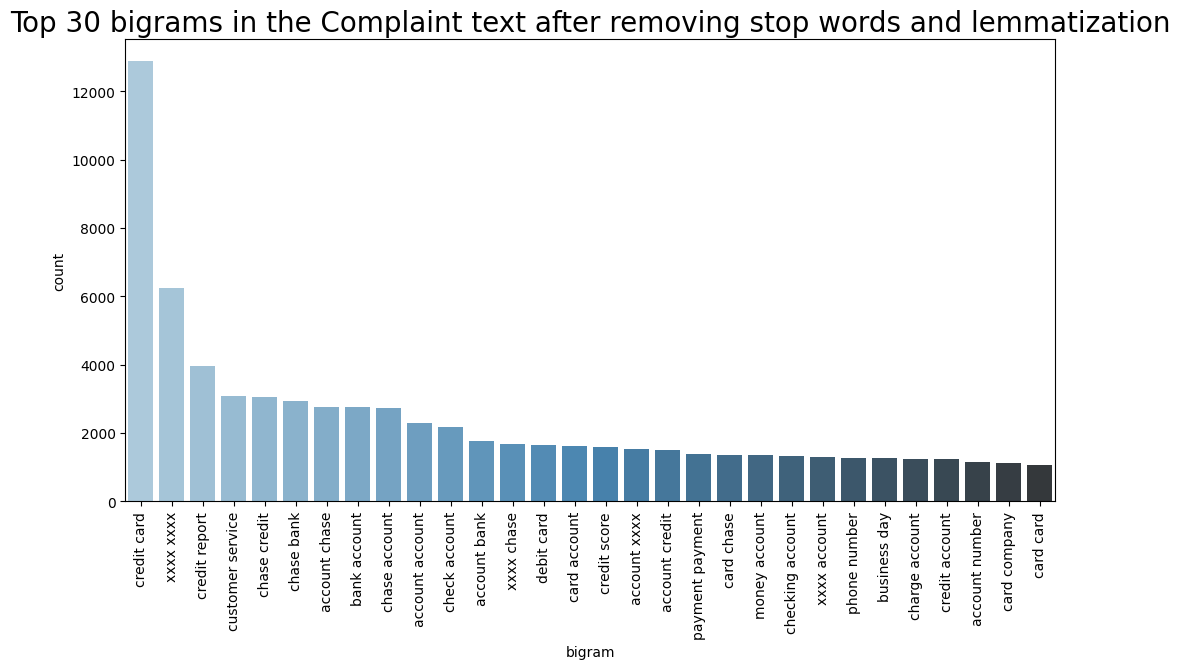

In [37]:
# Plot the top 30 bigrams
plt.figure(figsize=(12,6))
sns.barplot(x='bigram', y='count', data=df_bigram, palette="Blues_d")
plt.xticks(rotation=90)
plt.title("Top 30 bigrams in the Complaint text after removing stop words and lemmatization", fontsize=20)
plt.show()

In [38]:
#Print the top 10 words in the trigram frequency
print('Top 10 trigrams:\n')

df_trigram = pd.DataFrame(top_30_trigrams, columns = ['trigram' , 'count'])
df_trigram.head(10)

Top 10 trigrams:



,trigram,count
0,chase credit card,2140
1,xxxx xxxx xxxx,1063
2,credit card account,1056
3,credit card company,995
4,credit card chase,673
5,credit card credit,506
6,inquiry credit report,483
7,charge credit card,430
8,account credit card,414
9,card credit card,382


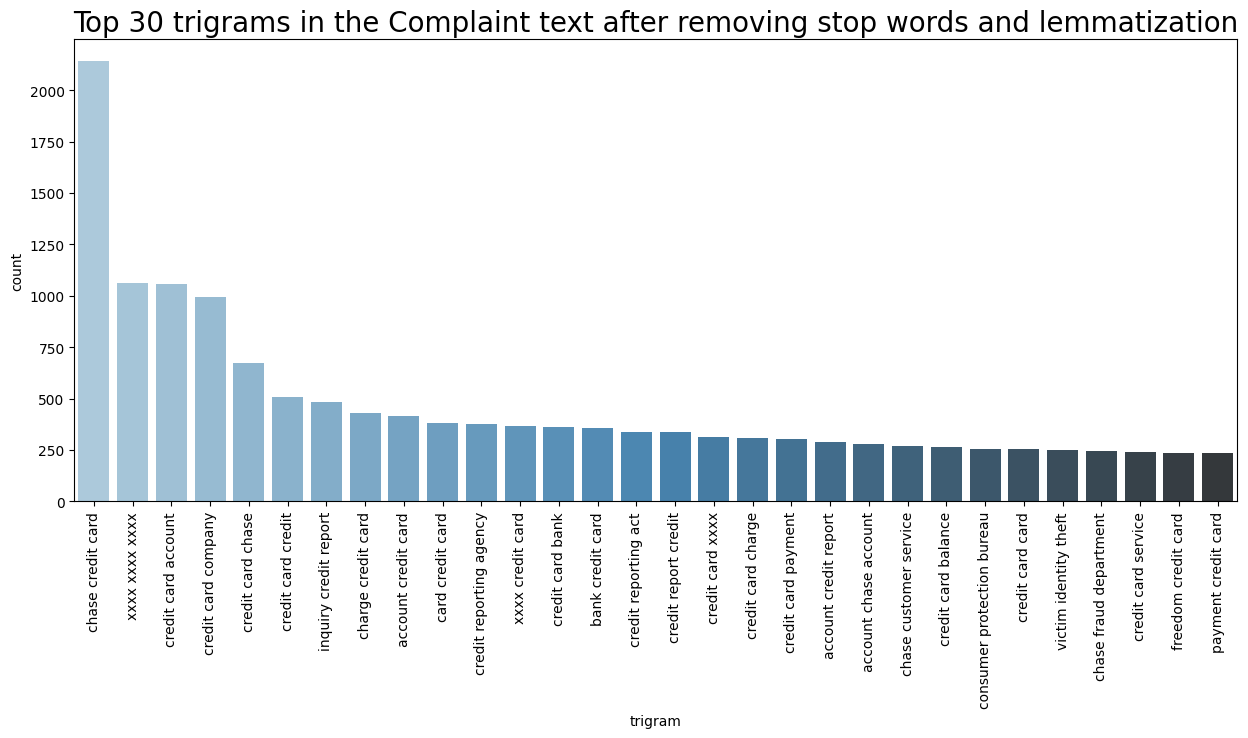

In [39]:
# Plot the top 30 trigrams
plt.figure(figsize=(15,6))
sns.barplot(x='trigram', y='count', data=df_trigram, palette="Blues_d")
plt.xticks(rotation=90)
plt.title("Top 30 trigrams in the Complaint text after removing stop words and lemmatization", fontsize=20)
plt.show()

In [40]:
df_clean['complaint_POS_removed'] = df_clean['complaint_POS_removed'].str.replace('xxxx','')

In [41]:
#All masked texts has been removed
df_clean.head()

,complaint_text,lemmatized_complaint,complaint_POS_removed
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember service ask ...
2,i upgraded my xxxx xxxx card in xx/xx/ and was...,I upgrade my xxxx xxxx card in xx / xx/ and be...,card agent upgrade date agent information orde...
10,"chase card was reported on xx/xx/. however, fr...","chase card be report on xx / xx/. however , fr...",card application identity consent service cred...
11,"on xx/xx/, while trying to book a xxxx xxxx ...","on xx / xx/ , while try to book a xxxx xxxx ...",try book ticket offer ticket card information...
14,my grand son give me check for {$.} i deposit ...,my grand son give I check for { $ . } I deposi...,son chase account fund bank account pay money ...


## 6. Feature Extraction

In [42]:
#Write your code here to initialise the TfidfVectorizer
tfidf = TfidfVectorizer(min_df=2, max_df=0.95, stop_words='english')

In [43]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.
dtm = tfidf.fit_transform(df_clean.complaint_POS_removed)

In [44]:
dtm

<21072x7077 sparse matrix of type '<class 'numpy.float64'>'
	with 656988 stored elements in Compressed Sparse Row format>

In [45]:
# Use get_feature_names_out() instead of get_feature_names()
tfidf.get_feature_names_out()[:10]

array(['aa', 'aarp', 'abandon', 'abandonment', 'abatement',
       'abbreviation', 'abd', 'abide', 'ability', 'abovementione'],
      dtype=object)

## 7. Topic Modelling using NMF (Non-Matrix Factorization)

In [46]:
from sklearn.decomposition import NMF

In [47]:
#Load your nmf_model with the n_components i.e 5
num_topics =  5

#keep the random_state =40
nmf_model = NMF(n_components=num_topics, random_state=40)

In [48]:
nmf_model.fit(dtm)
len(tfidf.get_feature_names_out())

7077

In [49]:
# Print the top word of a sample component
topic_single = nmf_model.components_[0]
topic_single.argsort()
top_word_index = topic_single.argsort()[-20:]
for index in top_word_index:
    print(tfidf.get_feature_names_out()[index])

time
access
fraud
cash
checking
customer
transfer
claim
transaction
business
number
day
branch
deposit
chase
fund
money
bank
check
account


In [50]:
#Print the Top20 words for each of the topics
for index, topic in enumerate(nmf_model.components_):
    print(f'TOP 20 WORDS FOR TOPIC #{index}')
    print([tfidf.get_feature_names_out()[i] for i in topic.argsort()[-20:]])
    print('\n')

TOP 20 WORDS FOR TOPIC #0
['time', 'access', 'fraud', 'cash', 'checking', 'customer', 'transfer', 'claim', 'transaction', 'business', 'number', 'day', 'branch', 'deposit', 'chase', 'fund', 'money', 'bank', 'check', 'account']


TOP 20 WORDS FOR TOPIC #1
['time', 'reason', 'bureaus', 'identity', 'reporting', 'year', 'balance', 'letter', 'application', 'debt', 'information', 'limit', 'company', 'score', 'account', 'chase', 'inquiry', 'report', 'card', 'credit']


TOP 20 WORDS FOR TOPIC #2
['option', 'plan', 'history', 'error', 'car', 'mortgage', 'year', 'chase', 'account', 'credit', 'date', 'pay', 'time', 'day', 'auto', 'statement', 'fee', 'month', 'balance', 'payment']


TOP 20 WORDS FOR TOPIC #3
['state', 'customer', 'email', 'day', 'phone', 'company', 'refund', 'statement', 'time', 'service', 'claim', 'purchase', 'fraud', 'merchant', 'dispute', 'transaction', 'fee', 'chase', 'card', 'charge']


TOP 20 WORDS FOR TOPIC #4
['process', 'debt', 'request', 'state', 'information', 'sale', 'h

In [51]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4

topic_result = nmf_model.transform(dtm)
topic_result[0].round(2)
topic_result[0].argmax()
topic_result.argmax(axis=1)

array([4, 1, 1, ..., 3, 2, 2])

In [52]:
# Create a new 'Topic' column and assign the best topic to each of the complaints

df_clean['Topic'] = topic_result.argmax(axis=1)

In [53]:
df_clean.shape

(21072, 4)

In [54]:
df_clean.head()

,complaint_text,lemmatized_complaint,complaint_POS_removed,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember service ask ...,4
2,i upgraded my xxxx xxxx card in xx/xx/ and was...,I upgrade my xxxx xxxx card in xx / xx/ and be...,card agent upgrade date agent information orde...,1
10,"chase card was reported on xx/xx/. however, fr...","chase card be report on xx / xx/. however , fr...",card application identity consent service cred...,1
11,"on xx/xx/, while trying to book a xxxx xxxx ...","on xx / xx/ , while try to book a xxxx xxxx ...",try book ticket offer ticket card information...,1
14,my grand son give me check for {$.} i deposit ...,my grand son give I check for { $ . } I deposi...,son chase account fund bank account pay money ...,0


In [55]:
#Print the first 5 Complaint for each of the Topics
df_clean_5=df_clean.groupby('Topic').head(5)
df_clean_5.sort_values('Topic')

,complaint_text,lemmatized_complaint,complaint_POS_removed,Topic
17,with out notice j.p. morgan chase restricted m...,with out notice j.p . morgan chase restrict my...,j.p chase account debit card tuesday branch cu...,0
14,my grand son give me check for {$.} i deposit ...,my grand son give I check for { $ . } I deposi...,son chase account fund bank account pay money ...,0
24,mishandling of this account by chase auto and ...,mishandle of this account by chase auto and xx...,mishandle account auto,0
27,i opened an account with chase bank on xxxx an...,I open an account with chase bank on xxxx and ...,account bank code bonus term everything accoun...,0
35,i opened the saving account for the {$.} bonus...,I open the save account for the { $ . } bonus ...,save account bonus bonus auto transfer check t...,0
15,can you please remove inquiry,can you please remove inquiry,inquiry,1
2,i upgraded my xxxx xxxx card in xx/xx/ and was...,I upgrade my xxxx xxxx card in xx / xx/ and be...,card agent upgrade date agent information orde...,1
10,"chase card was reported on xx/xx/. however, fr...","chase card be report on xx / xx/. however , fr...",card application identity consent service cred...,1
11,"on xx/xx/, while trying to book a xxxx xxxx ...","on xx / xx/ , while try to book a xxxx xxxx ...",try book ticket offer ticket card information...,1
23,i have a chase credit card which is incorrectl...,I have a chase credit card which be incorrectl...,chase credit card datum credit report company ...,1


## 8. Mapping Relevant Topic to Each Complaint

In [56]:
#Create the dictionary of Topic names and Topics
topic_mapping = {
    0: 'Bank Account services',
    1: 'Credit card or prepaid card',
    2: 'Others',
    3: 'Theft/Dispute Reporting',
    4: 'Mortgage/Loan'
}

#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(topic_mapping)

In [57]:
df_clean.head()

,complaint_text,lemmatized_complaint,complaint_POS_removed,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember service ask ...,Mortgage/Loan
2,i upgraded my xxxx xxxx card in xx/xx/ and was...,I upgrade my xxxx xxxx card in xx / xx/ and be...,card agent upgrade date agent information orde...,Credit card or prepaid card
10,"chase card was reported on xx/xx/. however, fr...","chase card be report on xx / xx/. however , fr...",card application identity consent service cred...,Credit card or prepaid card
11,"on xx/xx/, while trying to book a xxxx xxxx ...","on xx / xx/ , while try to book a xxxx xxxx ...",try book ticket offer ticket card information...,Credit card or prepaid card
14,my grand son give me check for {$.} i deposit ...,my grand son give I check for { $ . } I deposi...,son chase account fund bank account pay money ...,Bank Account services


<Axes: xlabel='Topic', ylabel='count'>

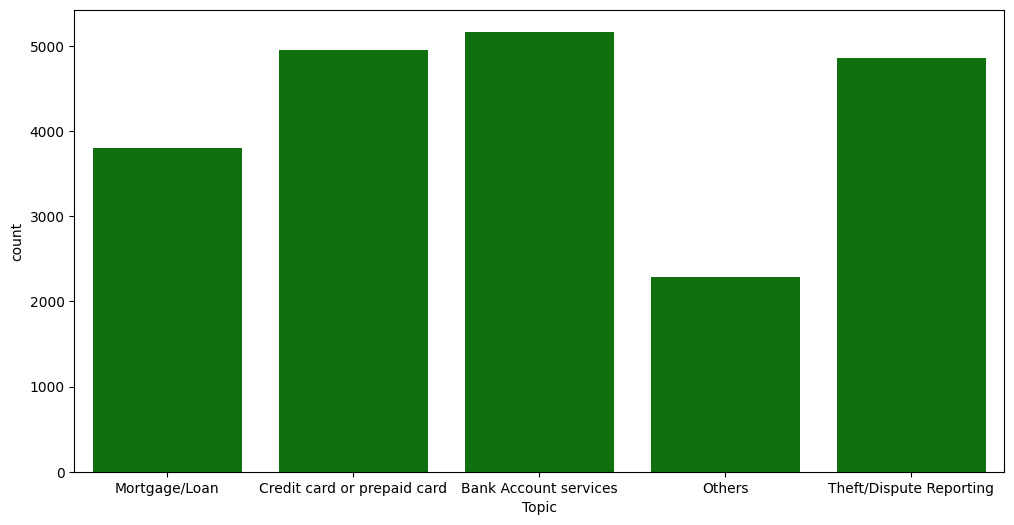

In [58]:
# Plot graph to check class imbalance
plt.figure(figsize=(12,6))
sns.countplot(x='Topic', data=df_clean, color = 'Green')

## 9. Build the Supervised Model for making a prediction for new complaint

In [59]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data

training_data = df_clean[['complaint_text','Topic']]

In [60]:
training_data.head()

,complaint_text,Topic
1,good morning my name is xxxx xxxx and i apprec...,Mortgage/Loan
2,i upgraded my xxxx xxxx card in xx/xx/ and was...,Credit card or prepaid card
10,"chase card was reported on xx/xx/. however, fr...",Credit card or prepaid card
11,"on xx/xx/, while trying to book a xxxx xxxx ...",Credit card or prepaid card
14,my grand son give me check for {$.} i deposit ...,Bank Account services


In [61]:
training_data['complaint_text'] = training_data['complaint_text'].str.replace('xxxx','')
training_data.head()

,complaint_text,Topic
1,good morning my name is and i appreciate it ...,Mortgage/Loan
2,i upgraded my card in xx/xx/ and was told by...,Credit card or prepaid card
10,"chase card was reported on xx/xx/. however, fr...",Credit card or prepaid card
11,"on xx/xx/, while trying to book a ticket, ...",Credit card or prepaid card
14,my grand son give me check for {$.} i deposit ...,Bank Account services


In [62]:
# View value counts of the five topics
training_data['Topic'].value_counts()

,count
Topic,
Bank Account services,5168
Credit card or prepaid card,4954
Theft/Dispute Reporting,4860
Mortgage/Loan,3808
Others,2282


## 10. Data Preprocessing

In [63]:
## Reverse topic names mapping for supervised learning

reverse_topic_mapping = {
    'Bank Account services' :0,
    'Credit card or prepaid card':1,
    'Others':2,
    'Theft/Dispute Reporting':3,
    'Mortgage/Loan':4
}
#Replace Topics with Topic Names
training_data['Topic'] = training_data['Topic'].map(reverse_topic_mapping)
training_data.head()

,complaint_text,Topic
1,good morning my name is and i appreciate it ...,4
2,i upgraded my card in xx/xx/ and was told by...,1
10,"chase card was reported on xx/xx/. however, fr...",1
11,"on xx/xx/, while trying to book a ticket, ...",1
14,my grand son give me check for {$.} i deposit ...,0


In [64]:

#Write your code to get the Vector count
count_vector=CountVectorizer()

#Write your code here to transform the word vector to tf-idf
X_train_count=count_vector.fit_transform(training_data['complaint_text'])

In [69]:
# Saving Word Vector on disk for later usage
import pickle

pickle.dump(count_vector.vocabulary_, open("/content/drive/MyDrive/Case Study NLP - Automatic Ticket Classification/count_vector.pkl","wb"))

In [65]:
# Transform the word vector to tf-idf
tfidf_transform= TfidfTransformer()
X_train_tfidf = tfidf_transform.fit_transform(X_train_count)

In [71]:
# Save TF-IDF on disk for later usage
pickle.dump(tfidf_transform, open("/content/drive/MyDrive/Case Study NLP - Automatic Ticket Classification/tfidf.pkl","wb"))

In [66]:
# Train-Test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, training_data.Topic, test_size=0.20, random_state=42)

print(f"X_train Shape: {X_train.shape}")
print(f"y_train Shape: {y_train.shape}")
print(f"X_test Shape: {X_test.shape}")
print(f"y_test Shape: {y_test.shape}")

X_train Shape: (16857, 27542)
y_train Shape: (16857,)
X_test Shape: (4215, 27542)
y_test Shape: (4215,)


## 11. Model Building & Evaluation

In [67]:
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_fscore_support

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [68]:
# Create a function to evaluate models
def model_eval(y_test, y_pred, model_name):

    # print classification report of classifier
    print(f"CLASSIFICATION REPORT for {model_name}\n")
    print(classification_report(y_test, y_pred, target_names=["Bank Account services", "Credit card or prepaid card", "Others", "Theft/Dispute Reporting",
"Mortgage/Loan"]))

    # plot confusion matrix of the classifier
    plt.figure(figsize=(10,7))
    plt.title(f"CONFUSION MATRIX for {model_name}\n")
    matrix = confusion_matrix(y_test, y_pred)
    sns.heatmap(matrix, annot=True, cbar=None, cmap="Greens", fmt='d', xticklabels=["Bank Account services", "Credit card or prepaid card", "Others", "Theft/Dispute Reporting",
"Mortgage/Loan"], yticklabels=["Bank Account services", "Credit card or prepaid card", "Others", "Theft/Dispute Reporting",
"Mortgage/Loan"])
    plt.show()

    return

### **Model 1. Naive Bayes**

In [69]:
# Import required library
from sklearn.naive_bayes import MultinomialNB

In [70]:
# Run the Multinomial Naive Bayes with default parameters

model_name = 'NAIVE BAYES'
nb = MultinomialNB()
nb.fit(X_train, y_train)

MultinomialNB()

In [71]:
y_pred_nb = nb.predict(X_test)

In [72]:
# Calculate F1 Score of model using weighted average method
f1_nb = f1_score(y_test, y_pred_nb, average="weighted")
f1_nb

0.6913360203121504

CLASSIFICATION REPORT for NAIVE BAYES

                             precision    recall  f1-score   support

      Bank Account services       0.67      0.91      0.77      1043
Credit card or prepaid card       0.73      0.77      0.75      1036
                     Others       0.89      0.02      0.03       449
    Theft/Dispute Reporting       0.73      0.79      0.76       973
              Mortgage/Loan       0.85      0.78      0.81       714

                   accuracy                           0.73      4215
                  macro avg       0.77      0.65      0.63      4215
               weighted avg       0.75      0.73      0.69      4215



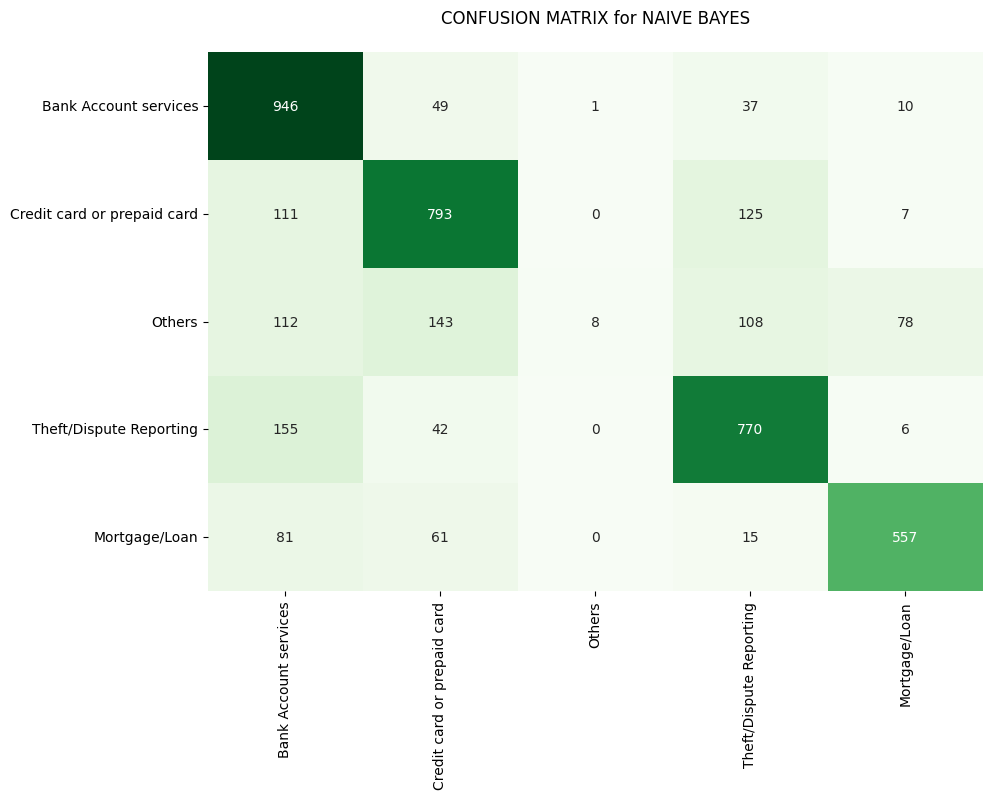

In [73]:
# Evaluate the Naive Bayes classifier
model_eval(y_test, y_pred_nb, model_name)

### **Model 2. Logistic Regression**

In [74]:
# Import required library
from sklearn.linear_model import LogisticRegression

In [75]:
# Run the Logistic Regression model with default parameters
model_name = 'LOGISTIC REGRESSION'
lr = LogisticRegression()
lr.fit(X_train, y_train)


LogisticRegression()

In [76]:
# Making Prediction with test data
y_pred_lr = lr.predict(X_test)

In [77]:
# Calculate F1 Score of tuned model using weighted average method
f1_lr = f1_score(y_test, y_pred_lr, average="weighted")
f1_lr

0.9230544907684372

CLASSIFICATION REPORT for LOGISTIC REGRESSION

                             precision    recall  f1-score   support

      Bank Account services       0.92      0.95      0.93      1043
Credit card or prepaid card       0.92      0.94      0.93      1036
                     Others       0.96      0.88      0.92       449
    Theft/Dispute Reporting       0.90      0.90      0.90       973
              Mortgage/Loan       0.94      0.93      0.94       714

                   accuracy                           0.92      4215
                  macro avg       0.93      0.92      0.92      4215
               weighted avg       0.92      0.92      0.92      4215



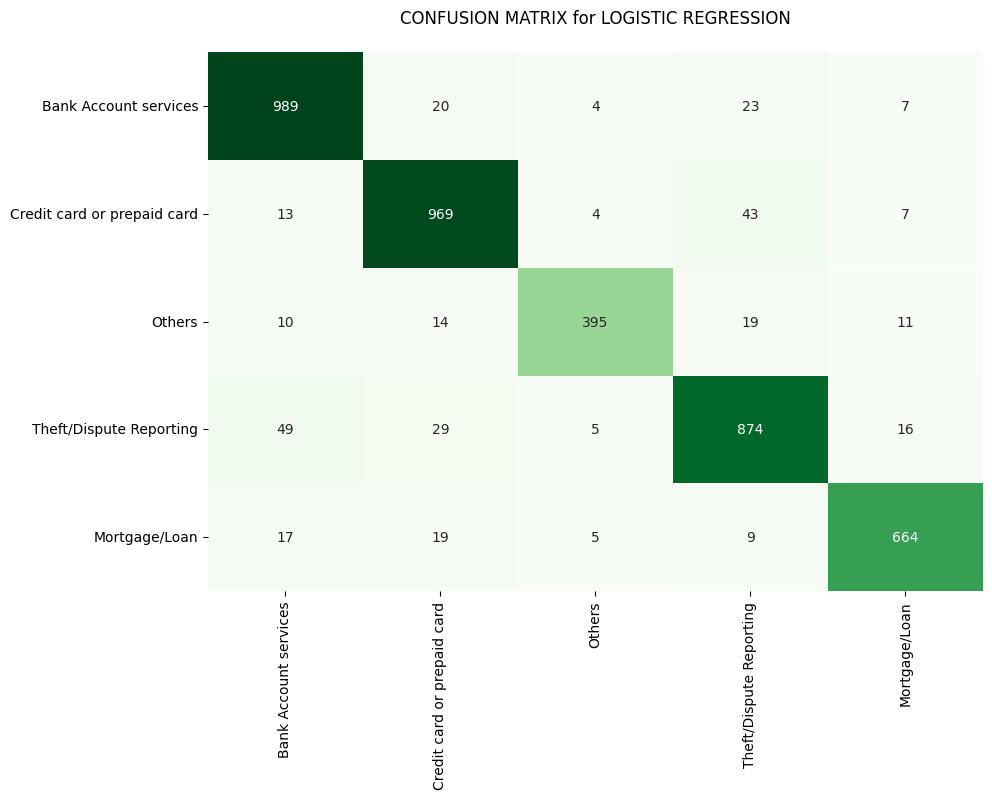

In [78]:
# Evaluate the tuned Logistic Regression classifier
model_eval(y_test, y_pred_lr, model_name)

### **Model 3. Decision Tree**

In [79]:
# Import required library
from sklearn.tree import DecisionTreeClassifier

In [80]:
# Run Decision Tree with default hyperparameters
model_name = 'DECISION TREE'
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)


DecisionTreeClassifier()

In [81]:
y_pred_dt =dt.predict(X_test)

In [82]:
# Calculate F1 Score of tuned model using weighted average method
f1_dt = f1_score(y_test, y_pred_dt, average="weighted")
f1_dt

0.7743329003726357

CLASSIFICATION REPORT for DECISION TREE

                             precision    recall  f1-score   support

      Bank Account services       0.77      0.80      0.79      1043
Credit card or prepaid card       0.81      0.82      0.81      1036
                     Others       0.72      0.71      0.72       449
    Theft/Dispute Reporting       0.74      0.71      0.73       973
              Mortgage/Loan       0.82      0.79      0.80       714

                   accuracy                           0.77      4215
                  macro avg       0.77      0.77      0.77      4215
               weighted avg       0.77      0.77      0.77      4215



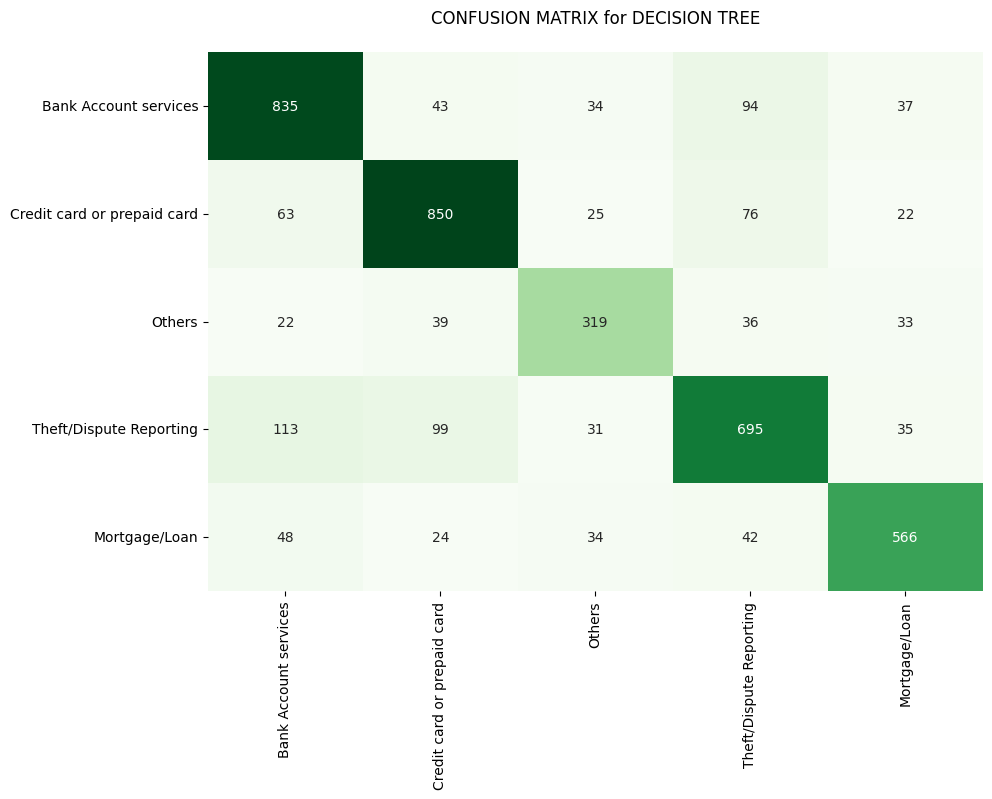

In [83]:
# Evaluate the tuned Decision Tree classifier
model_eval(y_test, y_pred_dt, model_name)

### **Model 4. Random Forest**

In [84]:
# Import required library
from sklearn.ensemble import RandomForestClassifier

In [85]:
# Run Decision Tree with default hyperparameters
model_name = 'RANDOM FOREST'
rf = RandomForestClassifier()
rf.fit(X_train, y_train)


RandomForestClassifier()

In [86]:
# Making Prediction on Test Data

y_pred_rf =rf.predict(X_test)

In [87]:
# Calculate F1 Score of tuned model using weighted average method
f1_rf = f1_score(y_test, y_pred_rf, average="weighted")
f1_rf

0.8168893705937272

CLASSIFICATION REPORT for RANDOM FOREST

                             precision    recall  f1-score   support

      Bank Account services       0.79      0.92      0.85      1043
Credit card or prepaid card       0.81      0.87      0.84      1036
                     Others       0.94      0.44      0.60       449
    Theft/Dispute Reporting       0.82      0.81      0.82       973
              Mortgage/Loan       0.86      0.88      0.87       714

                   accuracy                           0.82      4215
                  macro avg       0.85      0.78      0.80      4215
               weighted avg       0.83      0.82      0.82      4215



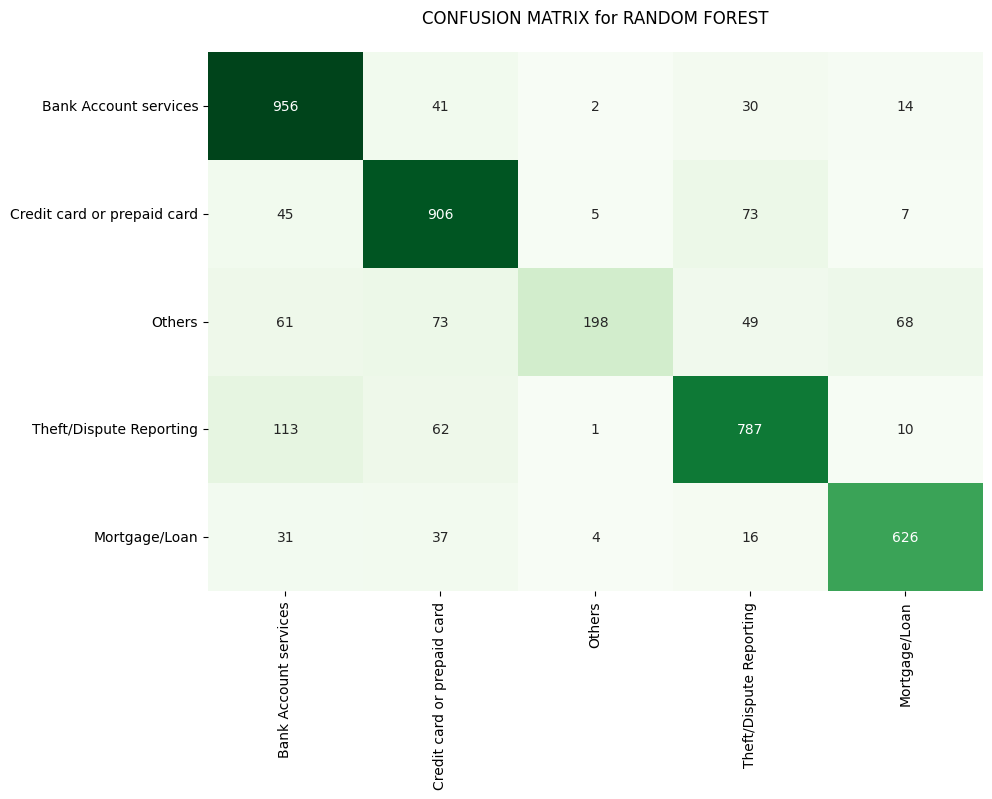

In [88]:
# Evaluate the tuned Decision Tree classifier
model_eval(y_test, y_pred_rf, model_name)

## **Predicting Category of New Complaint via Logistic Regression on custom text**


In [106]:
# Save Logistic Regression model as pickle file in device
pickle.dump(lr, open("/content/drive/MyDrive/Case Study NLP - Automatic Ticket Classification/logreg_model.pkl", "wb"))

In [107]:
# raw complaint text
test_complaint= 'I tried to make a transaction at a supermarket retail store, using my chase \
debit/atm card, but the transaction was declined. I am still able to withdraw money out of an \
ATM machine using the same debit card. Please resolve this issue.'

In [108]:
# vectorize and tf-idf tranform
test = count_vector.transform([test_complaint])
test_tfidf = tfidf_transform.transform(test)

In [109]:
# predict
prediction=lr.predict(test_tfidf)
prediction

array([3])

In [110]:
topic_mapping[prediction[0]]

'Theft/Dispute Reporting'

## **Create a list of Custom Complaints and then Predict the Category of Each Complaint**

In [14]:
# Function to predict a topic for custom text

def topic_predictor(text):

    target_names = ["Bank Account services", "Credit card or prepaid card", "Others", "Theft/Dispute Reporting", "Mortgage/Loan"]

    load_vec = CountVectorizer(vocabulary=pickle.load(open("/content/drive/MyDrive/Case Study NLP - Automatic Ticket Classification/count_vector.pkl", "rb")))
    load_tfidf = pickle.load(open("/content/drive/MyDrive/Case Study NLP - Automatic Ticket Classification/tfidf.pkl","rb"))
    load_model = pickle.load(open("/content/drive/MyDrive/Case Study NLP - Automatic Ticket Classification/logreg_model.pkl","rb"))

    X_new_count = load_vec.transform(text)
    X_new_tfidf = load_tfidf.transform(X_new_count)
    prediction = load_model.predict(X_new_tfidf)

    return target_names[prediction[0]]

In [15]:
# Create a dataframe of some sample customer complaints
import pandas as pd
df_custom = pd.DataFrame({'complaints': ["I can not get from chase who services my mortgage, who owns it and who has original loan docs",
                                  "The bill amount of my credit card was debited twice. Please look into the matter and resolve at the earliest.",
                                  "I want to open a salary account at your downtown branch. Please provide me the procedure.",
                                  "unwanted service activated and money deducted automatically ",
                                  "How can I know my CIBIL score?",
                                  "Where are the bank branches in the city of Patna?"]})
df_custom

,complaints
0,I can not get from chase who services my mortg...
1,The bill amount of my credit card was debited ...
2,I want to open a salary account at your downto...
3,unwanted service activated and money deducted ...
4,How can I know my CIBIL score?
5,Where are the bank branches in the city of Patna?


In [16]:
# Create a new column of predicted topics of each complaint, predicted using the tuned Logistic Regression model
df_custom['Predicted Category'] = df_custom['complaints'].apply(lambda x: topic_predictor([x]))
df_custom

,complaints,Predicted Category
0,I can not get from chase who services my mortg...,Mortgage/Loan
1,The bill amount of my credit card was debited ...,Credit card or prepaid card
2,I want to open a salary account at your downto...,Bank Account services
3,unwanted service activated and money deducted ...,Bank Account services
4,How can I know my CIBIL score?,Credit card or prepaid card
5,Where are the bank branches in the city of Patna?,Bank Account services


### ***We conclude that the Logistic Regression model is best for making a prediction on custom complaints data.***